## Лабораторная работа 2: Использование численных методов в задачах оптимизации
Команда 19
Рысаев, Семенихина, Павленко
### 1. Поиск минимума функции:

\begin{align}
f(x)= \frac {1}{2} [ (x_ {1})^ {2} + \sum _ {i=1}^ {2} (x_ {i}-x_ {i+1})^ {2} + (x_ {3})^ {2} ]- x_ {1}
\end{align}


##### Представление применимости алгоритмов BFGS и L-BFGS к данной оптимизационной задаче

После математических преобразований получаем исходную функцию в следующем виде:
$f(x) = x_1^2 - x_1x_2 + x_2^2 - x_2x_3 + x_3^2 - x_1$

Градиент функции от нескольких переменных это вектор от частных производных

$\frac{df}{dx_1} = 2x_1-x_2-1$, 
$\frac{df}{dx_2} = -x_1+2x_2-x_3$, 
$\frac{df}{dx_3} = -x_2+2x_3$

Как видим функция непрерывна

$\frac{{d^2f}}{{dx_1^2}} = 2$, $\frac{{d^2f}}{{dx_1 dx_2}} = -1$, $\frac{{d^2f}}{{dx_1 dx_3}} = 0$

$\frac{{d^2f}}{{dx_2 dx_1}} = -1$, $\frac{{d^2f}}{{dx^2_2}} = 2$, $\frac{{d^2f}}{{dx_2 dx_3}} = -1$

$\frac{{d^2f}}{{dx_3 dx_1}} = 0$, $\frac{{d^2f}}{{dx_3 dx_2}} = -1$, $\frac{{d^2f}}{{dx_3^2}} = 2$

Как видим функция дважды дифференцируема. Составим Гессиан H
$$ H = 
\begin{bmatrix}
    {2}       & {-1} & {0} &  \\
    {-1}       & {2} & {-1} &  \\
    {0}       & {-1} & {2} & 
\end{bmatrix} $$

In [1]:
import numpy as np

In [2]:
H = np.array([[2, -1, 0],
              [-1, 2, -1],
              [0, -1, 2]])

In [3]:
np.linalg.eigvals(H) 

array([3.41421356, 2.        , 0.58578644])

Собственные значения Гессиана больше нуля, функция выпуклая и есть минимум

In [4]:
def f(x):  # Исходная функция после матем преобразований
    return x[0]*x[0] - x[0]*x[1] + x[1]*x[1] - x[1]*x[2] + x[2]*x[2] - x[0]

In [5]:
def d1(x): # Первая производная, градиент-вектор функции из частных производных                       
    return np.array([2*x[0] - x[1] - 1, -x[0] + 2*x[1] - x[2], -x[1] + 2*x[2]])

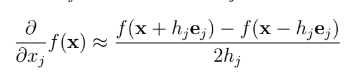

In [6]:
def d2(x, function=f, epsilon=7e-5): 
    grad = np.zeros_like(x)
    for i in range(x.shape[0]):
        he_plus, he_minus = x.copy(), x.copy()
        he_plus[i] += epsilon
        he_minus[i] -= epsilon
        grad[i] = 1/2 * (function(he_plus) - function(he_minus))/epsilon
    return grad

##### Реализация алгоритмов BFGS и L-BFGS

Вычисляем величину, на которую будем на каждом шаге k смещаться по направлению $p_k$ по условию Вольфе

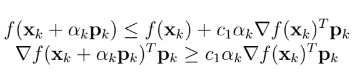

Приближение Гесииана делаем по формуле

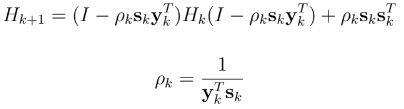

In [7]:
def linear_search(f, f_initial, x, p_direction_to_minimum):
    alpha = 1.0
    c = 1e-4
    rho = 0.9
    while f(x + alpha * p_direction_to_minimum) > f(x) + c * alpha * np.dot(f_initial(x), p_direction_to_minimum):
        alpha *= rho
    return alpha

In [8]:
def my_bfgs(f, f_initial, x0, max_iter=10000, epsilon=1e-5):
    cnt = 0
    I = np.eye(len(x0), dtype=float)                                
    H_k = I
    xk = x0
    grad = f_initial(x0)
    if max_iter is None:
        max_iter = len(x0)*1000
    while np.linalg.norm(grad) > epsilon and cnt < max_iter:
        pk = -np.dot(H_k, grad)
        alpha_k = linear_search(f, f_initial, xk, pk)
        xk_pk = xk + alpha_k * pk
        sk = xk_pk - xk
        xk = xk_pk
        grad_p1 = f_initial(xk_pk)
        yk = grad_p1 - grad
        grad = grad_p1
        ro = 1.0 / (yk @ sk)
        H_k = (I - ro * np.outer(sk, yk)) @ H_k @ (I - ro * np.outer(sk, yk)) + ro * np.outer(sk,sk)
        cnt += 1
    return xk, cnt

In [9]:
def my_lbfgs(f, f_initial, x0, max_iter=10000, epsilon=1e-5):
    xk = x0.copy()
    I = np.eye(len(x0))
    H_k = I
    for k in range(max_iter):
        grad = f_initial(xk)
        if np.linalg.norm(grad) < epsilon:
            break
        pk = -np.dot(H_k, grad)
        alpha_k = linear_search(f, f_initial, xk, pk)
        xk_pk = xk + alpha_k * pk
        sk = xk_pk - xk
        yk = f_initial(xk_pk) - grad
        if yk.dot(sk) > 0:
            ro = 1.0 / yk.dot(sk)
        sk = sk.reshape(-1,1)
        sk_dot_yk = sk*yk
        H_k = np.dot((I - ro * sk_dot_yk), H_k)
        H_k = np.dot(H_k, (I - ro * sk_dot_yk)) + ro * sk.dot(sk.T)
        xk = xk_pk
    return xk, k

##### Приближение матрицы Гессе

In [10]:
def hessian_approximation(f, x, epsilon=1e-5):
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            h_i = np.zeros(n)
            h_i[i] = 1
            h_j = np.zeros(n)
            h_j[j] = 1
            H[i,j] = (f(x+(h_i+h_j)*epsilon) - f(x+h_i*epsilon) - f(x+h_j*epsilon) + f(x)) / epsilon**2
    return H

In [11]:
np.round(hessian_approximation(f, np.array([999., 999., 999.]))) # Проверка работы на нашей фукции

array([[-1., -2.,  0.],
       [-2., -1., -2.],
       [ 0., -2.,  0.]])

Как видим результат совпадает с аналитическим решением

##### Сравнение алгоритмов BFGS и L-BFGS

In [12]:
import timeit
import scipy.optimize as opt
x = np.array([7., 777., 7777777.])

def func_to_measure():
    my_bfgs(f, d1, x, epsilon=1e-5)
    pass
print(' ')
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Поиск минимума BFGS аналитическим методом: {execution_time:.2f} секунд")
result, k = my_bfgs(f, d1, x, epsilon=10e-6)
print(f'Результат вычисления: {result}')
print(f'Количество итераций: {k}')
print('------------------------------------------------')

def func_to_measure():
    my_lbfgs(f, d1, x, epsilon=1e-5)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Поиск минимума L-BFGS аналитическим методом: {execution_time:.2f} секунд")
result, k = my_lbfgs(f, d1, x, epsilon=10e-6)
print(f'Результат вычисления: {result}')
print(f'Количество итераций: {k}')
print('======================================================')
print(' ')

def func_to_measure():
    my_bfgs(f, d2, x, epsilon=1e-5)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Поиск минимума BFGS численным методом: {execution_time:.2f} сек")
result, k = my_bfgs(f, d2, x, epsilon=10e-6)
print(f'Результат вычисления: {result}')
print(f'Количество итераций: {k}')
print('------------------------------------------------')

def func_to_measure():
    my_lbfgs(f, d2, x, epsilon=1e-5)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Поиск минимума L-BFGS численным методом: {execution_time:.2f} сек")
result, k = my_lbfgs(f, d2, x, epsilon=10e-6)
print(f'Результат вычисления: {result}')
print(f'Количество итераций: {k}')
print('======================================================')
print(' ')

def func_to_measure():
    result = opt.minimize(f, x, method='BFGS', tol=1e-5)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
result = opt.minimize(f, x, method='BFGS', tol=10e-6)
optimal_solution = result.x
print(f"Поиск минимума BFGS с помощью scipy.optimize: {execution_time:.2f} сек")
print(f'Результат вычисления: {result.x}')
print(f'Количество итераций: {result.nit}')
print('------------------------------------------------')

def func_to_measure():
    result = opt.minimize(f, x, method='L-BFGS-B', tol=1e-5)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
result = opt.minimize(f, x, method='L-BFGS-B', tol=10e-6)
print(f"Поиск минимума L-BFGS с помощью scipy.optimize: {execution_time:.2f} сек")
print(f'Результат вычисления: {result.x}')
print(f'Количество итераций: {result.nit}')
print(' ')

 
Поиск минимума BFGS аналитическим методом: 1.61 секунд
Результат вычисления: [0.7500028  0.5000077  0.25000694]
Количество итераций: 38
------------------------------------------------
Поиск минимума L-BFGS аналитическим методом: 1.42 секунд
Результат вычисления: [0.7500028  0.5000077  0.25000694]
Количество итераций: 38
 
Поиск минимума BFGS численным методом: 3.07 сек
Результат вычисления: [0.75000312 0.50000819 0.2500073 ]
Количество итераций: 38
------------------------------------------------
Поиск минимума L-BFGS численным методом: 3.10 сек
Результат вычисления: [0.75000312 0.50000819 0.2500073 ]
Количество итераций: 38
 
Поиск минимума BFGS с помощью scipy.optimize: 3.40 сек
Результат вычисления: [0.74999999 0.49999996 0.24999997]
Количество итераций: 11
------------------------------------------------
Поиск минимума L-BFGS с помощью scipy.optimize: 2.17 сек
Результат вычисления: [0.74999297 0.4999878  0.24999767]
Количество итераций: 10
 


Результаты вычислений у всех почти одинаковые. L-BFGS быстрее BFGS при аналитическом решении. В случае численных методов BFGS оказался быстрее L-BFGS (скорее всего из-за не оптимальных алгоритмов). Это особенно видно когда сравниваем BFGS и L-BFGS из библиотеки scipy, где алгоритмы поиска значительно лучше. L-BFGS из scipy нашел минимум быстрее (2.17сек против 3.40сек у BFGS из scipy) и за меньшее число итераций 

### 2. Практическое применение: использование метода оптимизации L-BFGS для решения задачи логистической регрессии

##### Представление набора данных

In [13]:
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

База данных по диабету индейцев пима.
Датасет скачан отсюда https://www.openml.org/search?type=data&sort=runs&status=any&qualities.NumberOfClasses=%3D_2&id=37
Формат arff сконвертирован в csv с помощью arffToCsv.py https://github.com/haloboy777/arfftocsv

In [14]:
from numpy import genfromtxt
data = pd.read_csv('/home/muratok/data/dataset_37_diabetes.csv')

In [15]:
'''
'preg' - Number of times pregnant
'plas' - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
'pres' - Diastolic blood pressure (mm Hg)
'skin' - Triceps skin fold thickness (mm)
'insu - '2-Hour serum insulin (mu U/ml)
'mass' - Body mass index (weight in kg/(height in m)^2)
'predi' - Diabetes pedigree function
'age' - Age (years)
'class' - Class variable (0 or 1)'''

"\n'preg' - Number of times pregnant\n'plas' - Plasma glucose concentration a 2 hours in an oral glucose tolerance test\n'pres' - Diastolic blood pressure (mm Hg)\n'skin' - Triceps skin fold thickness (mm)\n'insu - '2-Hour serum insulin (mu U/ml)\n'mass' - Body mass index (weight in kg/(height in m)^2)\n'predi' - Diabetes pedigree function\n'age' - Age (years)\n'class' - Class variable (0 or 1)"

In [16]:
data

'preg'  'plas'  'pres'  'skin'  'insu'  'mass'  'pedi'  'age'  \
0         6     148      72      35       0    33.6   0.627     50   
1         1      85      66      29       0    26.6   0.351     31   
2         8     183      64       0       0    23.3   0.672     32   
3         1      89      66      23      94    28.1   0.167     21   
4         0     137      40      35     168    43.1   2.288     33   
..      ...     ...     ...     ...     ...     ...     ...    ...   
763      10     101      76      48     180    32.9   0.171     63   
764       2     122      70      27       0    36.8   0.340     27   
765       5     121      72      23     112    26.2   0.245     30   
766       1     126      60       0       0    30.1   0.349     47   
767       1      93      70      31       0    30.4   0.315     23   

             'class'  
0    tested_positive  
1    tested_negative  
2    tested_positive  
3    tested_negative  
4    tested_positive  
..               ...  
763  tested_negative  
764  tested_negative  
765  tested_negative  
766  tested_positive  
767  tested_negative  

[768 rows x 9 columns]

In [17]:
amount_of_data = data.shape[0]

In [18]:
for i in range(amount_of_data):
    if data["'class'"][i] == 'tested_positive':
        data["'class'"][i] = '1'
    if data["'class'"][i] == 'tested_negative':
        data["'class'"][i] = '0'

In [19]:
y = data["'class'"].to_numpy()

In [20]:
y = y.astype(float)

In [21]:
df = data[["'preg'", "'plas'", "'pres'", "'skin'", "'insu'", "'mass'", "'pedi'", "'age'"]]

In [22]:
df.columns = range(8)

In [23]:
X = df.to_numpy().astype(float)

##### Реализация логистической регрессии

In [24]:
def centering(A):                                    # StandardScaler().fit_transform(data) - делает тоже самое
    B = np.copy(A)
    m, n = B.shape
    mean_columns = np.mean(B, axis=0)
    std_columns = np.std(B, axis=0)
    for i in range(m):
        for j in range(n):
            B[i,j] -= mean_columns[j]
            B[i,j] /= std_columns[j]
    return B

In [25]:
X = centering(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def loss_function(w):
    z = np.dot(X_train, w)
    return -np.sum(y_train * np.log(1 / (1 + np.exp(-z))) + (1 - y_train) * np.log(1 - 1 / (1 + np.exp(-z))))

In [28]:
def gradient_function(w):
    z = np.dot(X_train, w)
    p = 1 / (1 + np.exp(-z))
    return -np.dot(X_train.T, y_train - p)

In [29]:
def func(w, X, y):
    l2_coeff = 1
    matr = X.dot(w) * -y
    matr = np.logaddexp(0, matr)
    return 1 / X.shape[0] * np.sum(matr) + l2_coeff * np.dot(w[1:], w[1:])

In [30]:
x0 = np.zeros(X_train.shape[1])
optimal_weights, iterations = my_lbfgs(loss_function, gradient_function, x0, 1000, 1e-5)

def predict(X, weights):
    z = np.dot(X, weights)
    return 1 / (1 + np.exp(-z))

y_pred = predict(X_test, optimal_weights)
y_pred_binary = (y_pred >= 0.9).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)

print("Вектор оптимальных весов:\n", optimal_weights)
print("Количество шагов:", iterations)
print("Accuracy:", accuracy)

Вектор оптимальных весов:
 [ 0.21469172  1.06346709 -0.27528122  0.07695472 -0.24880559  0.67866571
  0.26083634  0.39360637]
Количество шагов: 142
Accuracy: 0.7142857142857143


In [31]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs')
model = clf.fit(X_train, y_train)
y_pred_sclrn = model.predict(X_test)

In [32]:
accuracy_sclrn = accuracy_score(y_test, y_pred_sclrn)
print("Accuracy с помощью sklearn LogisticRegression:", accuracy_sclrn )

Accuracy с помощью sklearn LogisticRegression: 0.7532467532467533


Как видим точность классификация на основе логической регрессии для данного набора данных не высокая, даже используя решение из библиотеки sklearn LogisticRegression. Скорее всего разделяющая поверхность не может поделить наши данные на два класса с большой точностью.

##### Сравнение характеристики работы алгоритмов

In [33]:
def func_to_measure():
    optimal_weights, iterations = my_bfgs(loss_function, gradient_function, x0)
    pass
execution_time = timeit.timeit(func_to_measure, number=1)
print(' ')
print(f"Решение с помощью BFGS: {execution_time:.2f} сек")
optimal_weights, iterations = my_bfgs(loss_function, gradient_function, x0)
print(f'Вектор весов:\n{optimal_weights}')
print(f'Количество шагов: {iterations}')
print('=================================================')
print(' ')

def func_to_measure():
    optimal_weights, iterations = my_lbfgs(loss_function, gradient_function, x0)
    pass
execution_time = timeit.timeit(func_to_measure, number=1)
print(f"Решение с помощью L-BFGS: {execution_time:.2f} сек")
optimal_weights, iterations = my_lbfgs(loss_function, gradient_function, x0)
print(f'Вектор весов:\n{optimal_weights}')
print(f'Количество шагов: {iterations}')
print('=================================================')
print(' ')

def func_to_measure():
    weights = result_scipy = opt.minimize(func, x0, method='L-BFGS-B', args=(X_train, y_train))
    pass
execution_time = timeit.timeit(func_to_measure, number=1)
print(f"Решение с помощью sklearn opt.minimize L-BFGS-B: {execution_time:.2f} сек")
weights = result_scipy = opt.minimize(func, x0, method='L-BFGS-B', args=(X_train, y_train))
print(f'Вектор весов:\n{optimal_weights}')
print(f'Количество шагов: {iterations}')

 
Решение с помощью BFGS: 0.05 сек
Вектор весов:
[ 0.21469172  1.06346709 -0.27528122  0.07695472 -0.24880559  0.67866571
  0.26083634  0.39360637]
Количество шагов: 142
 
Решение с помощью L-BFGS: 0.05 сек
Вектор весов:
[ 0.21469172  1.06346709 -0.27528122  0.07695472 -0.24880559  0.67866571
  0.26083634  0.39360637]
Количество шагов: 142
 
Решение с помощью sklearn opt.minimize L-BFGS-B: 0.01 сек
Вектор весов:
[ 0.21469172  1.06346709 -0.27528122  0.07695472 -0.24880559  0.67866571
  0.26083634  0.39360637]
Количество шагов: 142


Как видно из результатов значения весов совпадают со значениями, которые выдает sklearn opt.minimize. Все решения нашли веса за одинаковое число итераций. По времени выполнения быстрее оказался L-BFGS